Matplotlib is building the font cache; this may take a moment.


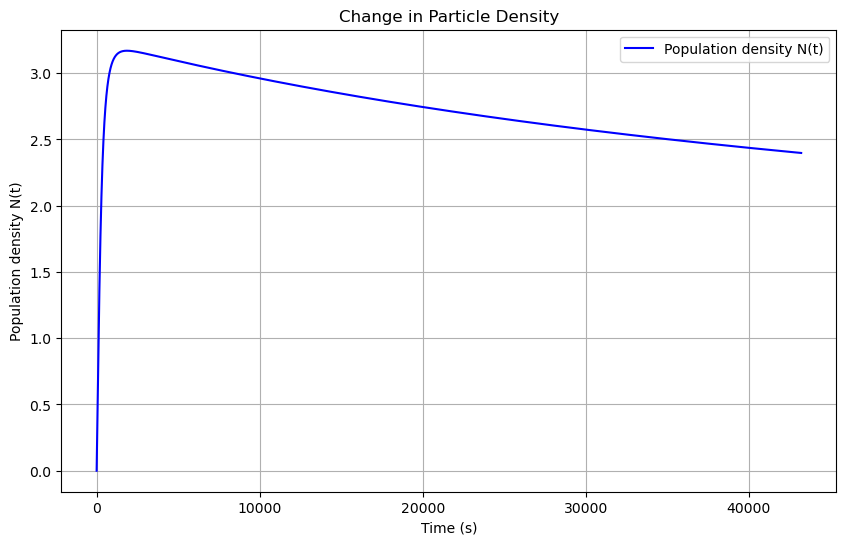

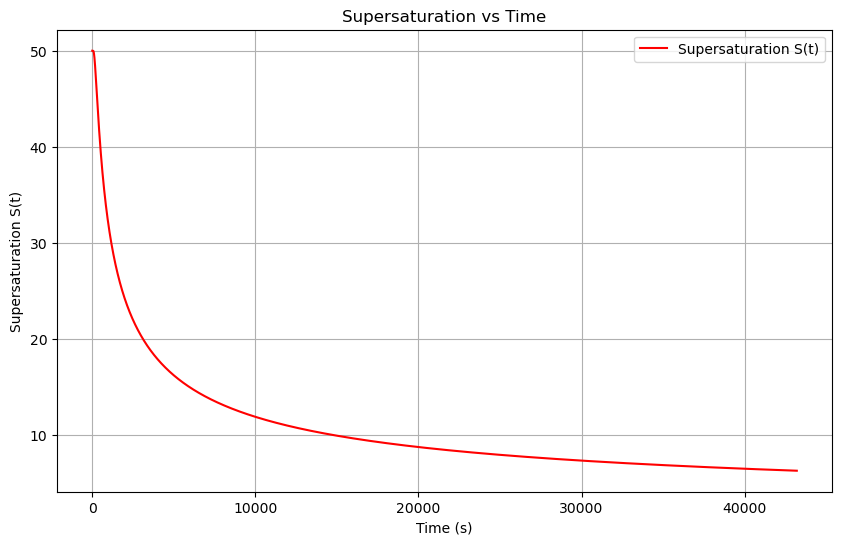

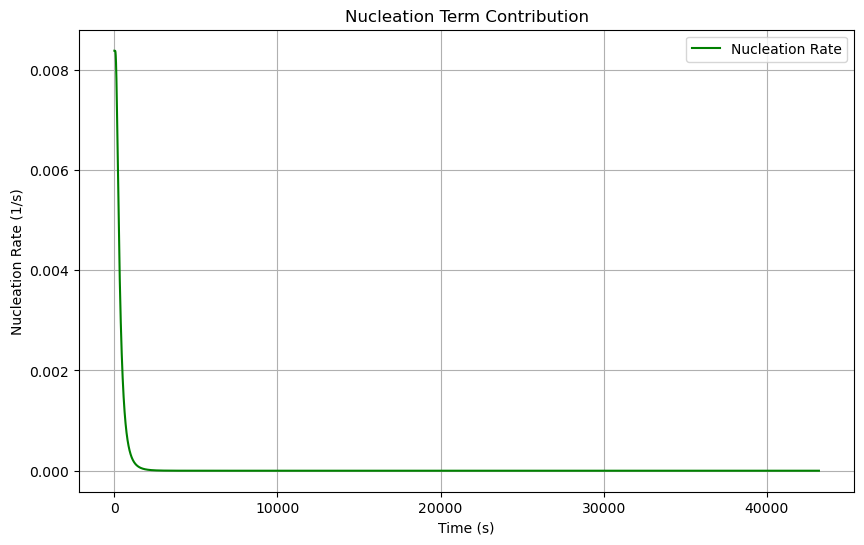

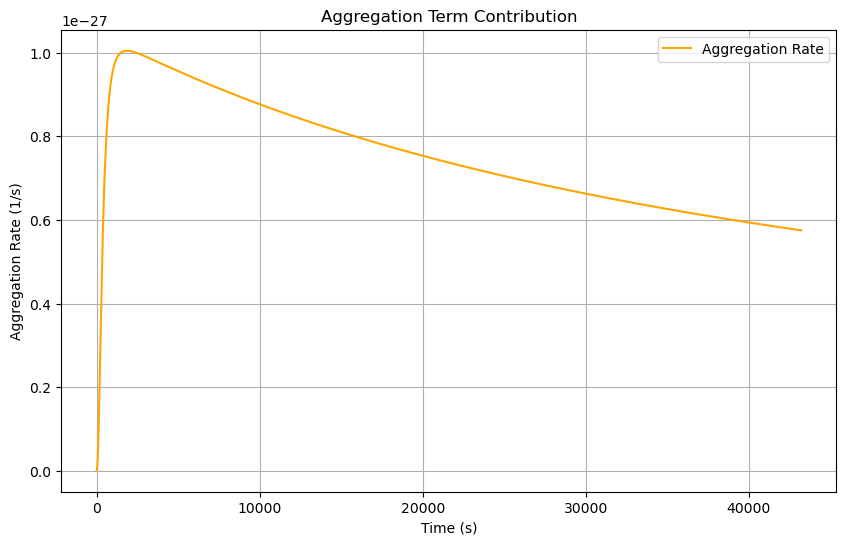

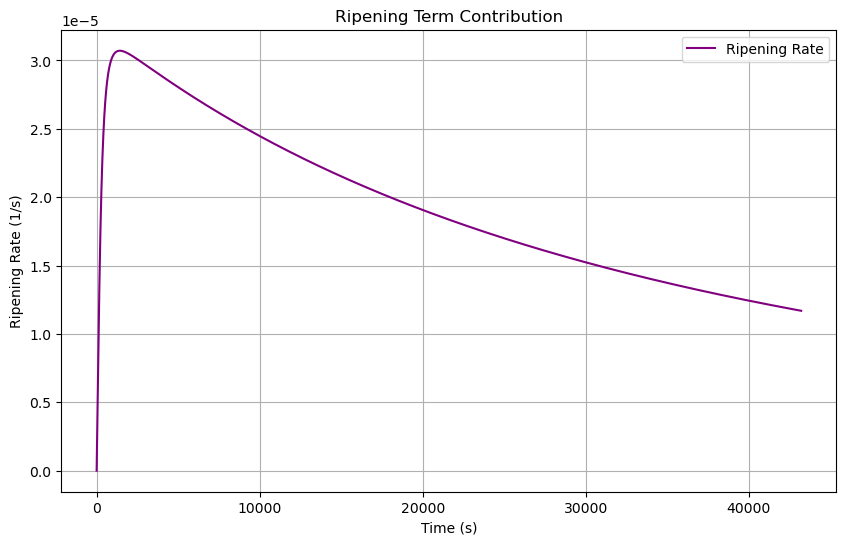

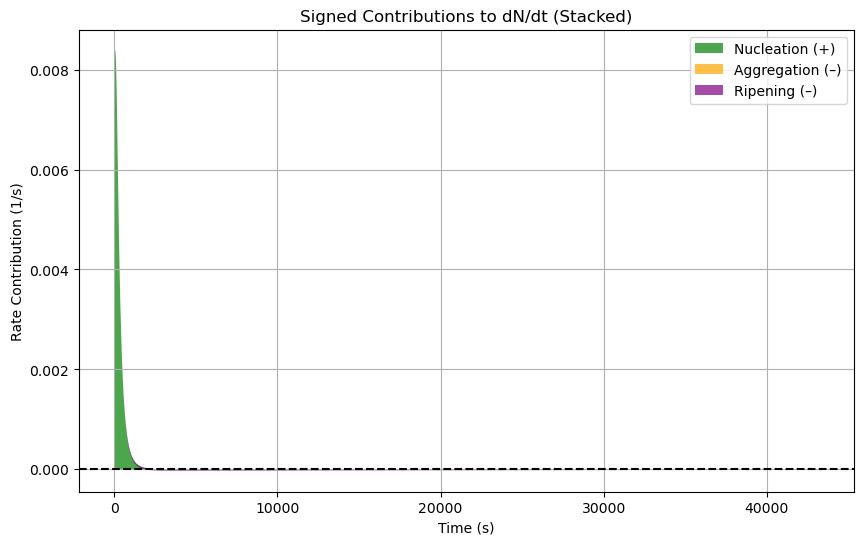

Colab 환경이 아니라면 다운로드는 생략됩니다.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import erfc
import pandas as pd

# ----------------------------
# 상수 설정 (단위 명시 포함)
# ----------------------------
A = 1e3        # 핵생성 항 계수 [1/(um^2·s)]
B = 178.9      # 핵생성 항 지수 계수 [무차원]
K_rip = 1e-5   # 라이프닝 계수 [1/s]
K_agg = 1e-28  # 응집 계수 [1/s]
S0 = 50       # 초기 과포화도 [무차원]

# ----------------------------
# 과포화도 함수 S(t): erfc 기반 확산 지배
# ----------------------------
def S(t):
    A_erfc = 49    # 감소량 계수
    B_erfc = 20     # 확산 깊이 계수
    return np.maximum(S0 - A_erfc * erfc(B_erfc / np.sqrt(t)), 1.000001)

# ----------------------------
# 입자 수 변화율 dN/dt 정의
# ----------------------------
def dNdt(t, N):
    N_val = N[0] if isinstance(N, (list, np.ndarray)) else N
    current_S = S(t)
    logS = np.log(current_S)

    # 각 항 계산
    nucleation = A * np.exp(-B / (logS ** 2))
    aggregation = 0 if N_val <= 0 else K_agg * N_val**2
    ripening = 0 if N_val <= 0 else K_rip * N_val / (1 + K_rip * t)**2

    dN_dt = nucleation - aggregation - ripening
    return [dN_dt]

# ----------------------------
# 시뮬레이션 실행
# ----------------------------
N0 = [0]
t_span = (1, 43200)  # t=0 대신 t=1부터 시작 (sqrt(0) 방지)
t_eval = np.linspace(t_span[0], t_span[1], 43200)

sol = solve_ivp(dNdt, t_span, N0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-9)

# ----------------------------
# 각 항 기여도 계산
# ----------------------------
nucleation_vals = []
aggregation_vals = []
ripening_vals = []

for t, N_val in zip(sol.t, sol.y[0]):
    current_S = S(t)
    logS = np.log(current_S)
    nucleation = A * np.exp(-B / (logS ** 2))
    aggregation = 0 if N_val <= 0 else K_agg * N_val**2
    ripening = 0 if N_val <= 0 else K_rip * N_val / (1 + K_rip * t)**2

    nucleation_vals.append(nucleation)
    aggregation_vals.append(aggregation)
    ripening_vals.append(ripening)

# ----------------------------
# 그래프 1: 입자 수 N(t)
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='Population density N(t)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Population density N(t)')
plt.title('Change in Particle Density')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 그래프 2: 과포화도 S(t)
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(sol.t, S(sol.t), label='Supersaturation S(t)', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Supersaturation S(t)')
plt.title('Supersaturation vs Time')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 그래프 3: 각 항의 변화율 개별 그래프
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(sol.t, nucleation_vals, label='Nucleation Rate', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Nucleation Rate (1/s)')
plt.title('Nucleation Term Contribution')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sol.t, aggregation_vals, label='Aggregation Rate', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Aggregation Rate (1/s)')
plt.title('Aggregation Term Contribution')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sol.t, ripening_vals, label='Ripening Rate', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Ripening Rate (1/s)')
plt.title('Ripening Term Contribution')
plt.grid(True)
plt.legend()
plt.show()

# ----------------------------
# 그래프 4: 각 항의 기여 스택플롯 (양/음 표시)
# ----------------------------
nucleation_arr = np.array(nucleation_vals)
aggregation_arr = -np.array(aggregation_vals)
ripening_arr = -np.array(ripening_vals)

plt.figure(figsize=(10, 6))
plt.stackplot(sol.t,
              nucleation_arr,
              aggregation_arr,
              ripening_arr,
              labels=['Nucleation (+)', 'Aggregation (–)', 'Ripening (–)'],
              colors=['green', 'orange', 'purple'],
              alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Rate Contribution (1/s)')
plt.title('Signed Contributions to dN/dt (Stacked)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# ----------------------------
# 결과 저장
# ----------------------------
df = pd.DataFrame({
    'Time (s)': sol.t,
    'Particle Number N(t)': sol.y[0],
    'Nucleation Rate': nucleation_vals,
    'Aggregation Rate': aggregation_vals,
    'Ripening Rate': ripening_vals,
    'Supersaturation S(t)': S(sol.t)
})
df.to_excel('exsolution_result_detailed.xlsx', index=False)

# ----------------------------
# Google Colab 다운로드용 (옵션)
# ----------------------------
try:
    from google.colab import files
    files.download('/content/exsolution_result_detailed.xlsx')
except:
    print("Colab 환경이 아니라면 다운로드는 생략됩니다.")


In [ ]:
#1차